# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 19.1 MB/s eta 0:00:00


In [ ]:
!pip install hmmlearn
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nilearn import plotting, datasets
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import itertools




In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquisition
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
# @title Download the data

# @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

import os, requests, tarfile

fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!


In [ ]:
# @title Extract the data in `HCP_DIR`
fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
  # open file
  path_name = os.path.join(HCP_DIR, fname)
  if not os.path.exists(path_name):
    print(f"Extracting {fname}.tgz...")
    with tarfile.open(f"{fname}.tgz") as fzip:
      fzip.extractall(HCP_DIR)
  else:
    print(f"File {fname}.tgz has already been extracted.")

Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [ ]:
with np.load(f"atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Loading in timeseries data for Rest and WM

Load a single run of resting-state data:

In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



Load a concatenated resting-state timeseries (using all runs' data) for each
subject and load in their WM timeseries data.

In [ ]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="rest",
                              dir=os.path.join(HCP_DIR, "hcp_rest"))
  timeseries_rest.append(ts_concat)
timeseries_rest = np.asarray(timeseries_rest)


timeseries_WM = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="WM",
                              dir=os.path.join(HCP_DIR, "hcp_task"))
  timeseries_WM.append(ts_concat)
timeseries_WM = np.asarray(timeseries_WM)


## Fit group-level HMM

In [ ]:
def get_hmm_model(timeseries_data, num_subjects, n_cortical_areas, n_time_points, n_latent_states):
  ## - for one subject
  # Extract data for the first subject and transpose to (n_time_points, n_cortical_areas)
  #data_raw = np.copy(timeseries_data[0, :, :n_time_points]).T
  #print(f"Original BOLD data shape (for one subject, after transpose): {data_raw.shape}")



  ## - for group-level
  # Initialize lists to store concatenated data and lengths for hmmlearn
  all_subjects_data_raw = []
  all_subjects_lengths = []

  print(f"\nExtracting and preparing data for {num_subjects} subjects, using {n_time_points} time points each...")

  for sub_idx in range(num_subjects):
      # Extract data for the current subject, all areas, and specified time points
      # Shape after extraction: (360, n_time_points)
      subject_data_extracted = np.copy(timeseries_data[sub_idx, :, :n_time_points])

      # Transpose to get (n_time_points, n_features) as required by HMMlearn
      subject_data_transposed = subject_data_extracted.T # Shape: (n_time_points, 360)

      all_subjects_data_raw.append(subject_data_transposed)
      all_subjects_lengths.append(subject_data_transposed.shape[0]) # Store length of this subject's sequence

  # Concatenate all subjects' raw data into one large matrix
  data_raw = np.concatenate(all_subjects_data_raw, axis=0)
  print(f"Concatenated raw data shape (all subjects): {data_raw.shape}")
  print(f"Lengths for HMM (first 5 and sum): {all_subjects_lengths[:5]} ... Sum: {sum(all_subjects_lengths)}")


  # --- 2. Preprocessing: Normalization (Z-scoring) ---
  # Z-scoring is crucial for fMRI BOLD data before HMM analysis.
  # It standardizes each regional time series to have a mean of 0 and a standard deviation of 1.
  # This helps the HMM's Gaussian emission models converge better and ensures
  # that differences in signal amplitude across regions don't bias the model.[1, 2, 3, 4, 5, 6, 7]
  scaler = StandardScaler()
  data_normalized = scaler.fit_transform(data_raw)
  print(f"Normalized data shape: {data_normalized.shape}")

  # --- 3. Prepare data for HMM (without PCA) ---
  # X_hmm now directly uses the normalized data.
  X_hmm = data_normalized
  print(np.shape(X_hmm))
  # For a single subject, 'lengths' is simply the total number of time points.[8, 9]
  lengths = [X_hmm.shape]
  print(lengths)
  lengths = np.repeat(n_time_points,num_subjects)
  lengths = [n_time_points] * num_subjects

  # --- 4. Initialize and Train the HMM ---

  # Initialize the Gaussian HMM.
  # 'covariance_type="diag"' is used here. Using 'full' with 360 features
  # would be computationally very expensive and highly prone to overfitting
  # without dimensionality reduction like PCA.[10, 11]
  # 'n_iter' and 'random_state' are set for reproducibility and convergence.[12, 8, 13, 11, 14, 15]
  print(f"\nInitializing and training HMM with {n_latent_states} hidden states...")
  model = hmm.GaussianHMM(n_components=n_latent_states, covariance_type="diag",
                          n_iter=100, tol=1e-2, random_state=42)


  # Fit the model to your preprocessed data.
  model.fit(X_hmm, lengths)
  print("HMM training complete.")
  print(f"Log-likelihood of the trained model: {model.score(X_hmm, lengths):.2f}")

  latent_states = model.predict(X_hmm, lengths)

  return model, latent_states

num_subjects = 339
num_subjects = 100
n_cortical_areas = 360
n_time_points = 1200
n_latent_states = 4

print(f"Shape of timeseries_rest: {np.shape(timeseries_rest)}")


rest_model, latent_brain_states = get_hmm_model(timeseries_rest, num_subjects, n_cortical_areas, n_time_points, n_latent_states)


Shape of timeseries_rest: (339, 360, 4800)

Extracting and preparing data for 100 subjects, using 1200 time points each...
Concatenated raw data shape (all subjects): (120000, 360)
Lengths for HMM (first 5 and sum): [1200, 1200, 1200, 1200, 1200] ... Sum: 120000
Normalized data shape: (120000, 360)
(120000, 360)
[(120000, 360)]

Initializing and training HMM with 4 hidden states...


KeyboardInterrupt: 


Shape of latent_brain_states (time series of state assignments): (120000,)
First 20 inferred hidden states: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last 20 inferred hidden states: [0 0 0 0 3 3 3 3 2 2 2 2 2 2 2 3 3 3 3 3]

Shape of state_mean_bold_patterns (mean BOLD activity for each state across 360 areas): (4, 360)
Mean BOLD pattern for State 0 (first 10 areas):
[0.25935828 0.23365626 0.26603639 0.30458386 0.28272352 0.27568865
 0.24120761 0.27323684 0.28224733 0.24597148]
Shape of Transition Probability Matrix: (4, 4)
Transition Probability Matrix:
 [[0.81416984 0.05715267 0.00214065 0.12653684]
 [0.13773714 0.82663191 0.02457121 0.01105974]
 [0.0076168  0.03805869 0.83841281 0.1159117 ]
 [0.14188991 0.00403357 0.03535178 0.81872473]]
Shape of Initial State Probabilities: (4,)
Initial State Probabilities: [0.08806101 0.74999132 0.09000371 0.07194397]
Shape of State Covariances (diagonal): (4, 360, 360)
Variances for State 0 (first 10 areas):
[[0.39881725 0.         0.         ..

/tmp/ipython-input-51-2115730257.py:216: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.view_surf(fsaverage['infl_left'], surf_contrast)


<Axes: >

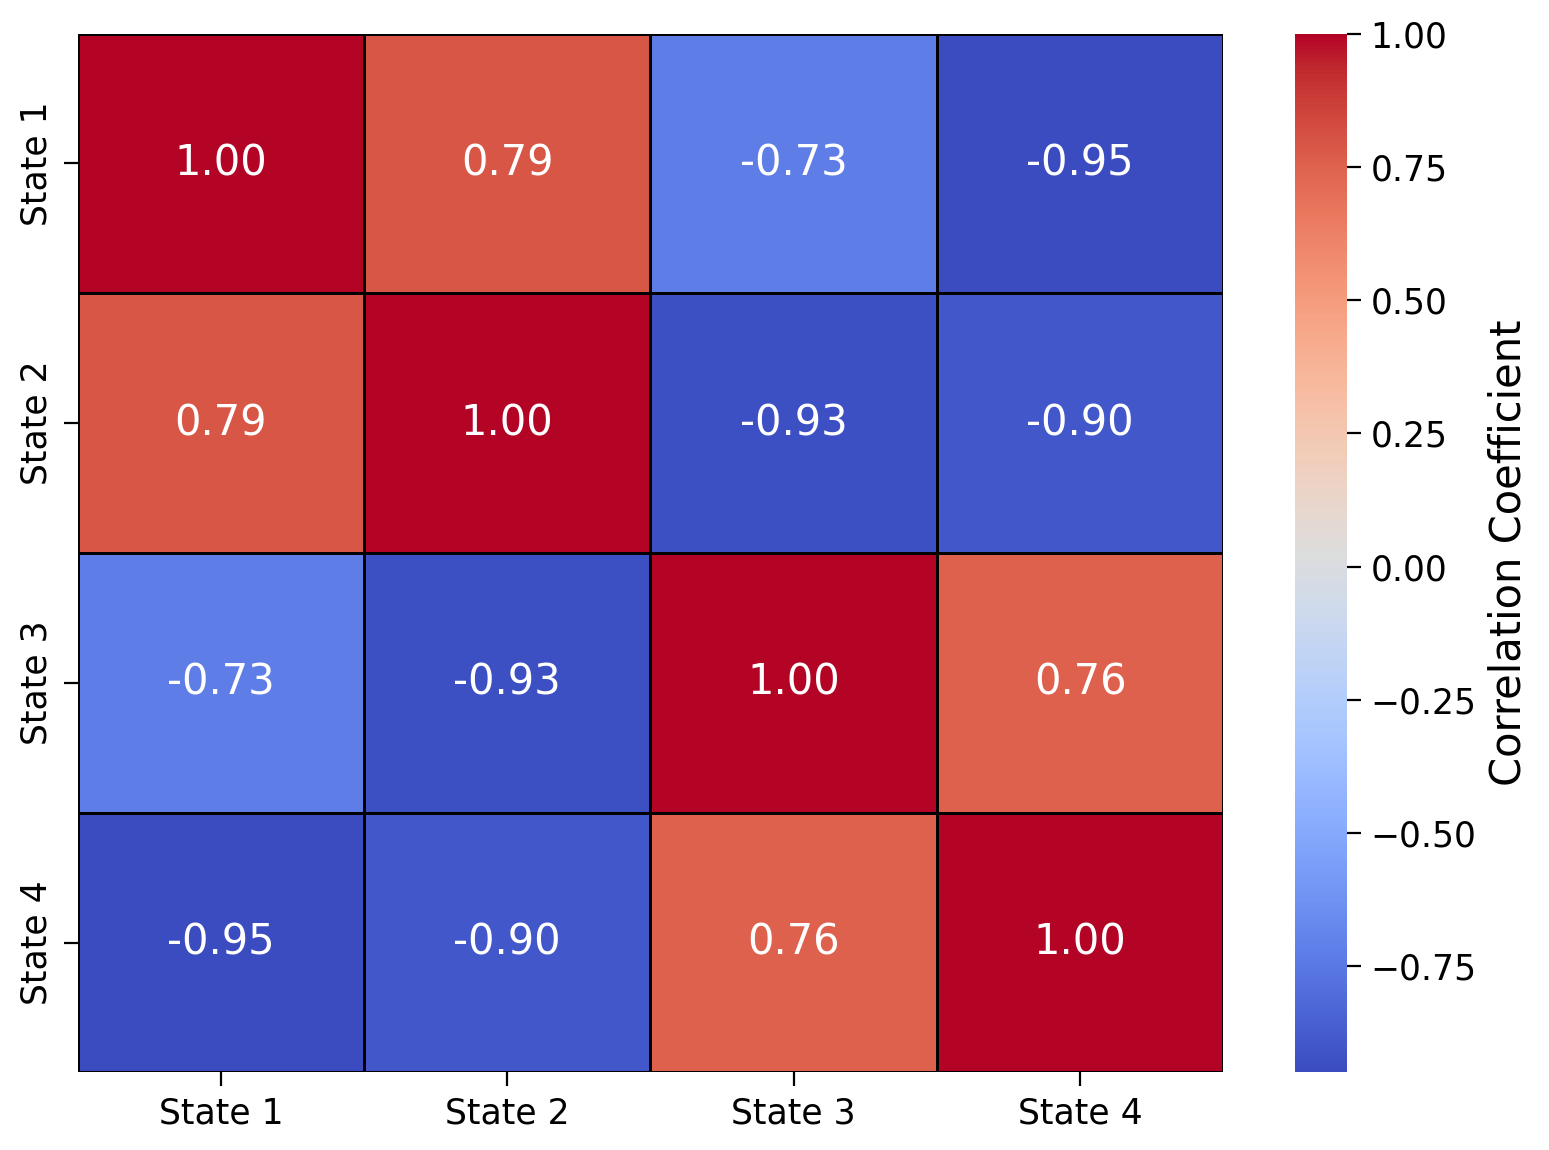

In [ ]:
# --- 5. Extract Hidden States ---
# Use the predict() method to infer the most likely sequence of hidden states.[12, 16, 8, 13, 17, 10, 14, 15]
# This output tells you which brain state the subject is in at each time point.

print(f"\nShape of latent_brain_states (time series of state assignments): {latent_brain_states.shape}")
print(f"First 20 inferred hidden states: {latent_brain_states[:20]}")
print(f"Last 20 inferred hidden states: {latent_brain_states[-20:]}")

# --- 6. Extract Mean BOLD Patterns for Each State ---
# The 'model.means_' attribute now directly gives the mean BOLD activation pattern
# for each state across the 360 cortical areas, as PCA was not applied.
state_mean_bold_patterns = rest_model.means_ # Shape: (n_latent_states, n_cortical_areas)

print(f"\nShape of state_mean_bold_patterns (mean BOLD activity for each state across 360 areas): {state_mean_bold_patterns.shape}")
print(f"Mean BOLD pattern for State 0 (first 10 areas):\n{state_mean_bold_patterns[0, :10]}")

# --- 7. Get transition probability matrix  ---
transition_probability_matrix = rest_model.transmat_
print(f"Shape of Transition Probability Matrix: {transition_probability_matrix.shape}")
print("Transition Probability Matrix:\n", transition_probability_matrix)


# --- 8. Get initial state probabilities  ---
initial_state_probabilities = rest_model.startprob_
print(f"Shape of Initial State Probabilities: {initial_state_probabilities.shape}")
print("Initial State Probabilities:", initial_state_probabilities)


# --- 9. Get Covariance Matrices for Each Stat  ---
state_covariances_diag = rest_model.covars_
print(f"Shape of State Covariances (diagonal): {state_covariances_diag.shape}")

# For a "diag" covariance_type, covars_ is (n_components, n_features)
# To get the full diagonal covariance matrix for a state, you'd do:
# np.diag(state_covariances_diag[state_index])

# Example: Variances for State 0 (first 10 areas)
print(f"Variances for State 0 (first 10 areas):\n{state_covariances_diag[0, :10]}")

# --- 10. Getting State Dwell Times and Fractional Occupancy  ---
unique_states = np.arange(n_latent_states)

all_subjects_lengths = [n_time_points] * num_subjects

# Calculate Fractional Occupancy
fractional_occupancy = np.array([np.sum(latent_brain_states == s) / len(latent_brain_states) for s in unique_states])
print("\nFractional Occupancy for each state:")
for i, fo in enumerate(fractional_occupancy):
    print(f"  State {i}: {fo:.4f}")

# Calculate Dwell Times (mean lifetime)
dwell_times = []
for s in unique_states:
    state_transitions = np.where(np.diff(latent_brain_states == s))[0]
    if len(state_transitions) == 0: # State is entered but never exited
        if np.all(latent_brain_states == s):
            dwell_times.append(len(latent_brain_states)) # If entire sequence is one state
        else:
            dwell_times.append(0) # State not entered
        continue

    # Find start and end points of each contiguous block of the state
    in_state_indices = np.where(latent_brain_states == s)[0]
    if len(in_state_indices) == 0:
        dwell_times.append(0)
        continue

    block_lengths = []
    current_length = 0
    for i in range(len(in_state_indices)):
        current_length += 1
        if i == len(in_state_indices) - 1 or in_state_indices[i+1] != in_state_indices[i] + 1:
            block_lengths.append(current_length)
            current_length = 0

    if len(block_lengths) > 0:
        dwell_times.append(np.mean(block_lengths))
    else:
        dwell_times.append(0) # Should not happen if in_state_indices is not empty

print("\nMean Dwell Time (in TRs) for each state:")
for i, dt in enumerate(dwell_times):
    print(f"  State {i}: {dt:.2f} TRs")

tr_seconds = 0.72
dwell_times_seconds = [dt * tr_seconds for dt in dwell_times]
print("Mean Dwell Time (in seconds) for each state:", dwell_times_seconds)


# --- 11. Getting Subject-level DT and FA   ---

# Initialize lists to store subject-specific results
subject_fractional_occupancies = []
subject_dwell_times = []
subject_trs_in_state = []   # New: Store number of TRs for each state per subject
subject_num_sojourns = []   # New: Store number of sojourns for each state per subject

current_idx = 0
for sub_idx, sub_length in enumerate(all_subjects_lengths):
    # Extract the latent states for the current subject
    subject_states = latent_brain_states[current_idx : current_idx + sub_length]

    # --- Calculate Fractional Occupancy & Number of TRs in State for the current subject ---
    subject_fo = np.zeros(n_latent_states)
    subject_trs_count = np.zeros(n_latent_states, dtype=int) # Initialize as integers
    for s in range(n_latent_states):
        count_trs = np.sum(subject_states == s)
        subject_trs_count[s] = count_trs
        subject_fo[s] = count_trs / sub_length
    subject_fractional_occupancies.append(subject_fo)
    subject_trs_in_state.append(subject_trs_count)


    # --- Calculate Dwell Time and Number of Sojourns for the current subject ---
    subject_dt = []
    subject_sojourns_count = np.zeros(n_latent_states, dtype=int) # Initialize as integers

    for s in range(n_latent_states):
        block_lengths = []

        # Pad the subject's state sequence to correctly identify blocks that
        # start or end at the sequence boundaries.
        # We assume a transition *out* of state 's' at the beginning if not in 's',
        # and *into* state 's' at the end if not in 's'.
        # This helps catch blocks starting at TR 0 or ending at the last TR.
        padded_subject_states_is_s = np.concatenate(([not (subject_states[0] == s)],
                                                     subject_states == s,
                                                     [not (subject_states[-1] == s)]))

        # Find indices where the state changes
        # A change point from False to True indicates the start of a block of state 's'
        # A change point from True to False indicates the end of a block of state 's'
        change_points = np.where(np.diff(padded_subject_states_is_s))[0]

        if len(change_points) % 2 != 0:
            print(f"Warning: Uneven change points for subject {sub_idx}, state {s}. Skipping dwell time and sojourn count for this state.")
            subject_dt.append(0)
            subject_sojourns_count[s] = 0 # No reliable sojourn count
            continue

        # Iterate through pairs of change points to get block lengths and count sojourns
        num_sojourns_for_state_s = 0
        for i in range(0, len(change_points), 2):
            start_index_in_padded = change_points[i]
            end_index_in_padded = change_points[i+1] # This is 1 past the end of the block

            # Check if this segment represents a block of state 's'
            # (i.e., we are entering state 's' at `start_index_in_padded`)
            if padded_subject_states_is_s[start_index_in_padded]:
                block_length = end_index_in_padded - start_index_in_padded
                if block_length > 0: # Ensure block has non-zero length
                    block_lengths.append(block_length)
                    num_sojourns_for_state_s += 1 # Count as an entry/sojourn

        if len(block_lengths) > 0:
            subject_dt.append(np.mean(block_lengths))
        else:
            subject_dt.append(0) # State 's' was never entered by this subject or only transiently

        subject_sojourns_count[s] = num_sojourns_for_state_s

    subject_dwell_times.append(subject_dt)
    subject_num_sojourns.append(subject_sojourns_count)

    # Move to the next subject's data in the concatenated sequence
    current_idx += sub_length

# Convert lists of arrays/lists to NumPy arrays for easier analysis
subject_fractional_occupancies = np.array(subject_fractional_occupancies)
subject_dwell_times = np.array(subject_dwell_times)
subject_trs_in_state = np.array(subject_trs_in_state)
subject_num_sojourns = np.array(subject_num_sojourns)

print("\n--- Subject-Specific Fractional Occupancies (FO) ---")
print("Shape (num_subjects, n_hidden_states):", subject_fractional_occupancies.shape)
print("First 5 subjects' FO (if num_subjects >= 5):")
print(subject_fractional_occupancies[:min(5, len(subject_fractional_occupancies))])

print("\n--- Subject-Specific Mean Dwell Times (DT) ---")
print("Shape (num_subjects, n_hidden_states):", subject_dwell_times.shape)
print("First 5 subjects' DT (if num_subjects >= 5):")
print(subject_dwell_times[:min(5, len(subject_dwell_times))])

print("\n--- Subject-Specific TRs in Each State ---")
print("Shape (num_subjects, n_hidden_states):", subject_trs_in_state.shape)
print("First 5 subjects' TRs in each state (if num_subjects >= 5):")
print(subject_trs_in_state[:min(5, len(subject_trs_in_state))])

print("\n--- Subject-Specific Number of Sojourns into Each State ---")
print("Shape (num_subjects, n_hidden_states):", subject_num_sojourns.shape)
print("First 5 subjects' Sojourns (if num_subjects >= 5):")
print(subject_num_sojourns[:min(5, len(subject_num_sojourns))])

# Example Averages
if len(subject_fractional_occupancies) > 0:
    print(f"\nAverage Fractional Occupancy for State 0 across all subjects: {np.mean(subject_fractional_occupancies[:, 0]):.4f}")
if len(subject_dwell_times) > 0:
    print(f"Average Mean Dwell Time for State 1 across all subjects: {np.mean(subject_dwell_times[:, 1]):.2f} TRs")
if len(subject_trs_in_state) > 0:
    print(f"Average Number of TRs in State 2 across all subjects: {np.mean(subject_trs_in_state[:, 2]):.2f} TRs")
if len(subject_num_sojourns) > 0:
    print(f"Average Number of Sojourns into State 3 across all subjects: {np.mean(subject_num_sojourns[:, 3]):.2f}")




## - save latend states and calculate cross-correlation
print(np.shape(state_mean_bold_patterns))

latent_state = state_mean_bold_patterns[0,[atlas["labels_L"]]]

#print(np.shape(latent_state))

fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = state_mean_bold_patterns[0,[atlas["labels_L"]]]
plotting.view_surf(fsaverage['infl_left'], surf_contrast)
plt.show()

np.savetxt('latent_states_n100_rest.csv', state_mean_bold_patterns, delimiter=',')

state_labels = [f'State {i+1}' for i in range(n_latent_states)]
sns.heatmap(np.corrcoef(state_mean_bold_patterns),
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=.5,
            linecolor='black',
            yticklabels=state_labels, xticklabels=state_labels,
            cbar_kws={'label': 'Correlation Coefficient'})



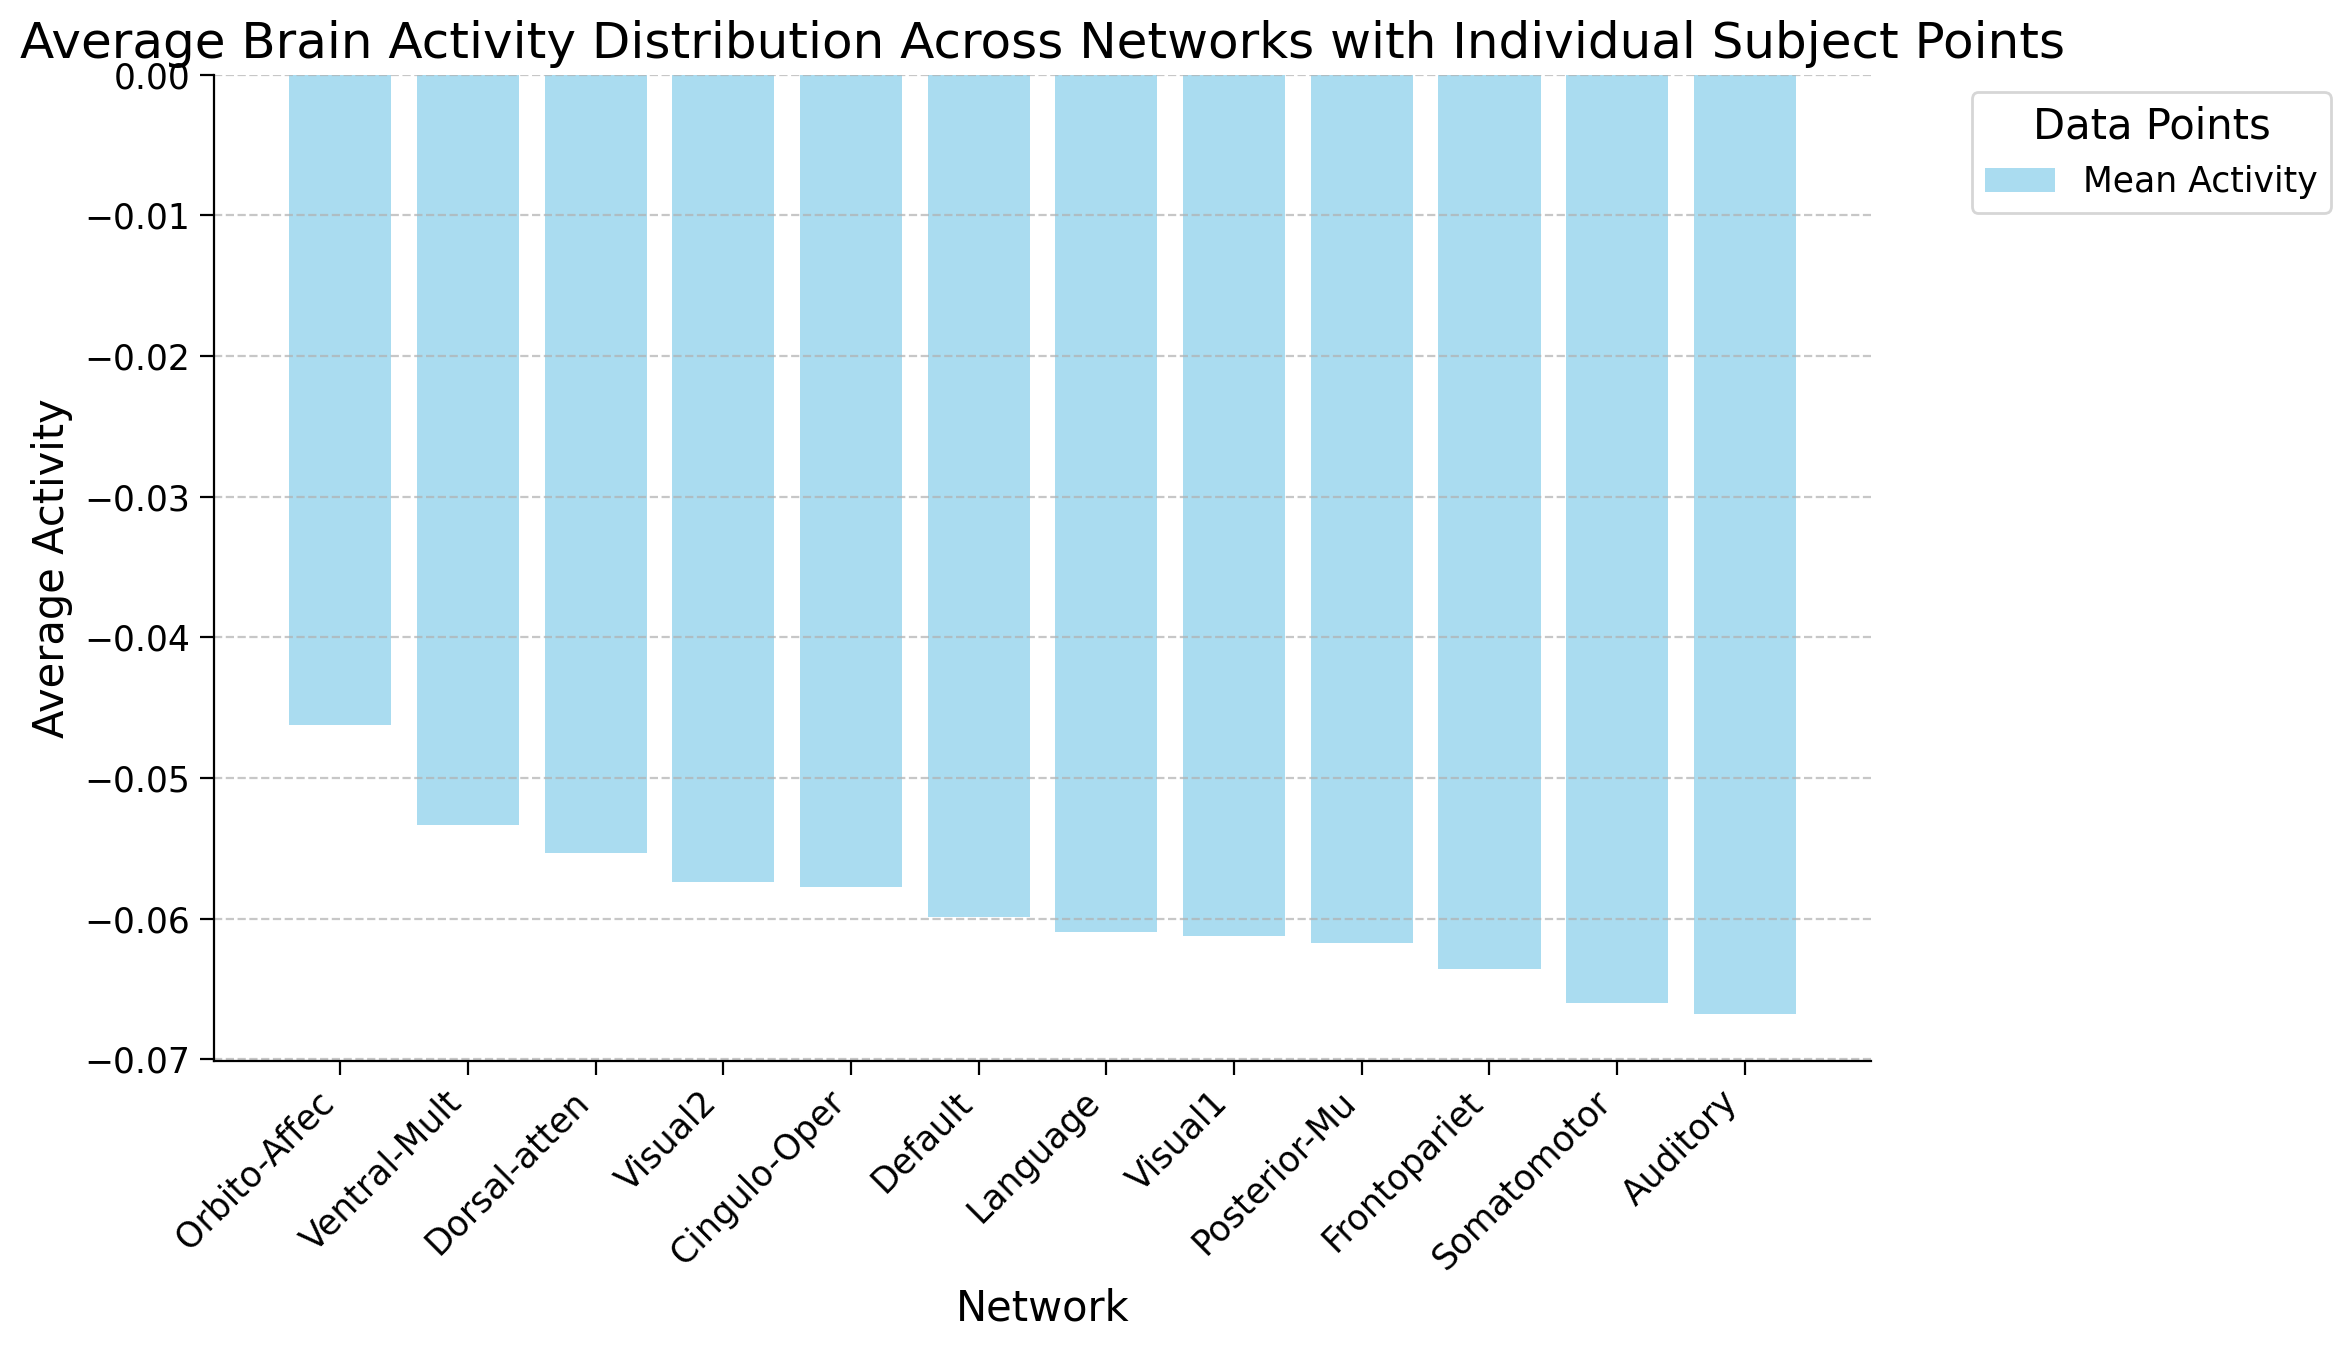

In [ ]:
'''
## -this should be where the code is to generate the
#state_mean_bold_patterns = np.copy(your_brain_state_matrix_name)

# Load fsaverage template surfaces
fsaverage = datasets.fetch_surf_fsaverage()

# Inspect data shape
print("Shape of state_mean_bold_patterns:", state_mean_bold_patterns.shape)
n_states = state_mean_bold_patterns.shape[0]

# Compute global vmin and vmax across all latent states
vmin = np.min(state_mean_bold_patterns)
vmax = np.max(state_mean_bold_patterns)
print(f"Using shared color scale: vmin={vmin:.2f}, vmax={vmax:.2f}")

# Plot a n_states by 2 columns image to show each of the unique brain states
fig, axes = plt.subplots(n_states, 2, figsize=(10, 12), subplot_kw={'projection': '3d'})

for state_idx in range(n_states):
    bold_pattern = state_mean_bold_patterns[state_idx]

    bold_L = bold_pattern[atlas["labels_L"]]
    bold_R = bold_pattern[atlas["labels_R"]]

    # left hemisphere
    plotting.plot_surf_stat_map(
        fsaverage["infl_left"],
        bold_L,
        hemi='left',
        colorbar=False,
        title=f"State {state_idx + 1} - Left",
        axes=axes[state_idx, 0],
        figure=fig,
        vmax=vmax,
        vmin=vmin
    )

    # right hemisphere
    plotting.plot_surf_stat_map(
        fsaverage["infl_right"],
        bold_R,
        hemi='right',
        colorbar=False,
        title=f"State {state_idx + 1} - Right",
        axes=axes[state_idx, 1],
        figure=fig,
        vmax=vmax,
        vmin=vmin
    )


# Add cbar to bottom
cax = fig.add_axes([0.35, 0.1, 0.3, 0.02])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cb = colorbar.ColorbarBase(cax, cmap="cold_hot", norm=norm, orientation='horizontal')
cb.set_label("Mean activation (BOLD)")

plt.tight_layout(rect=[0, 0.12, 1, 1])
plt.show()

'''

## - get network related info
# Prepare data for plotting
df_long = pd.DataFrame(state_mean_bold_patterns.T, columns=subject_ids)
df_long['network'] = region_info['network']
df_melted = df_long.melt(id_vars=['network'], var_name='Subject', value_name='Activity')

# Calculate mean activity for bars
network_mean_activity = df_melted.groupby('network')['Activity'].mean().sort_values(ascending=False)

# Calculate subject activity per network for points
subject_network_activity = df_melted.groupby(['network', 'Subject'])['Activity'].mean().unstack(level='Subject')
subject_network_activity = subject_network_activity.reindex(network_mean_activity.index)


# --- Plotting ---
plt.figure(figsize=(12, 7))

# Bar plot of mean activity
plt.bar(network_mean_activity.index, network_mean_activity.values, color='skyblue', alpha=0.7, label='Mean Activity')

# Overlay individual subject points
x_coords = np.arange(len(network_mean_activity))
plt.title('Average Brain Activity Distribution Across Networks with Individual Subject Points')
plt.xlabel('Network')
plt.ylabel('Average Activity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Points', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


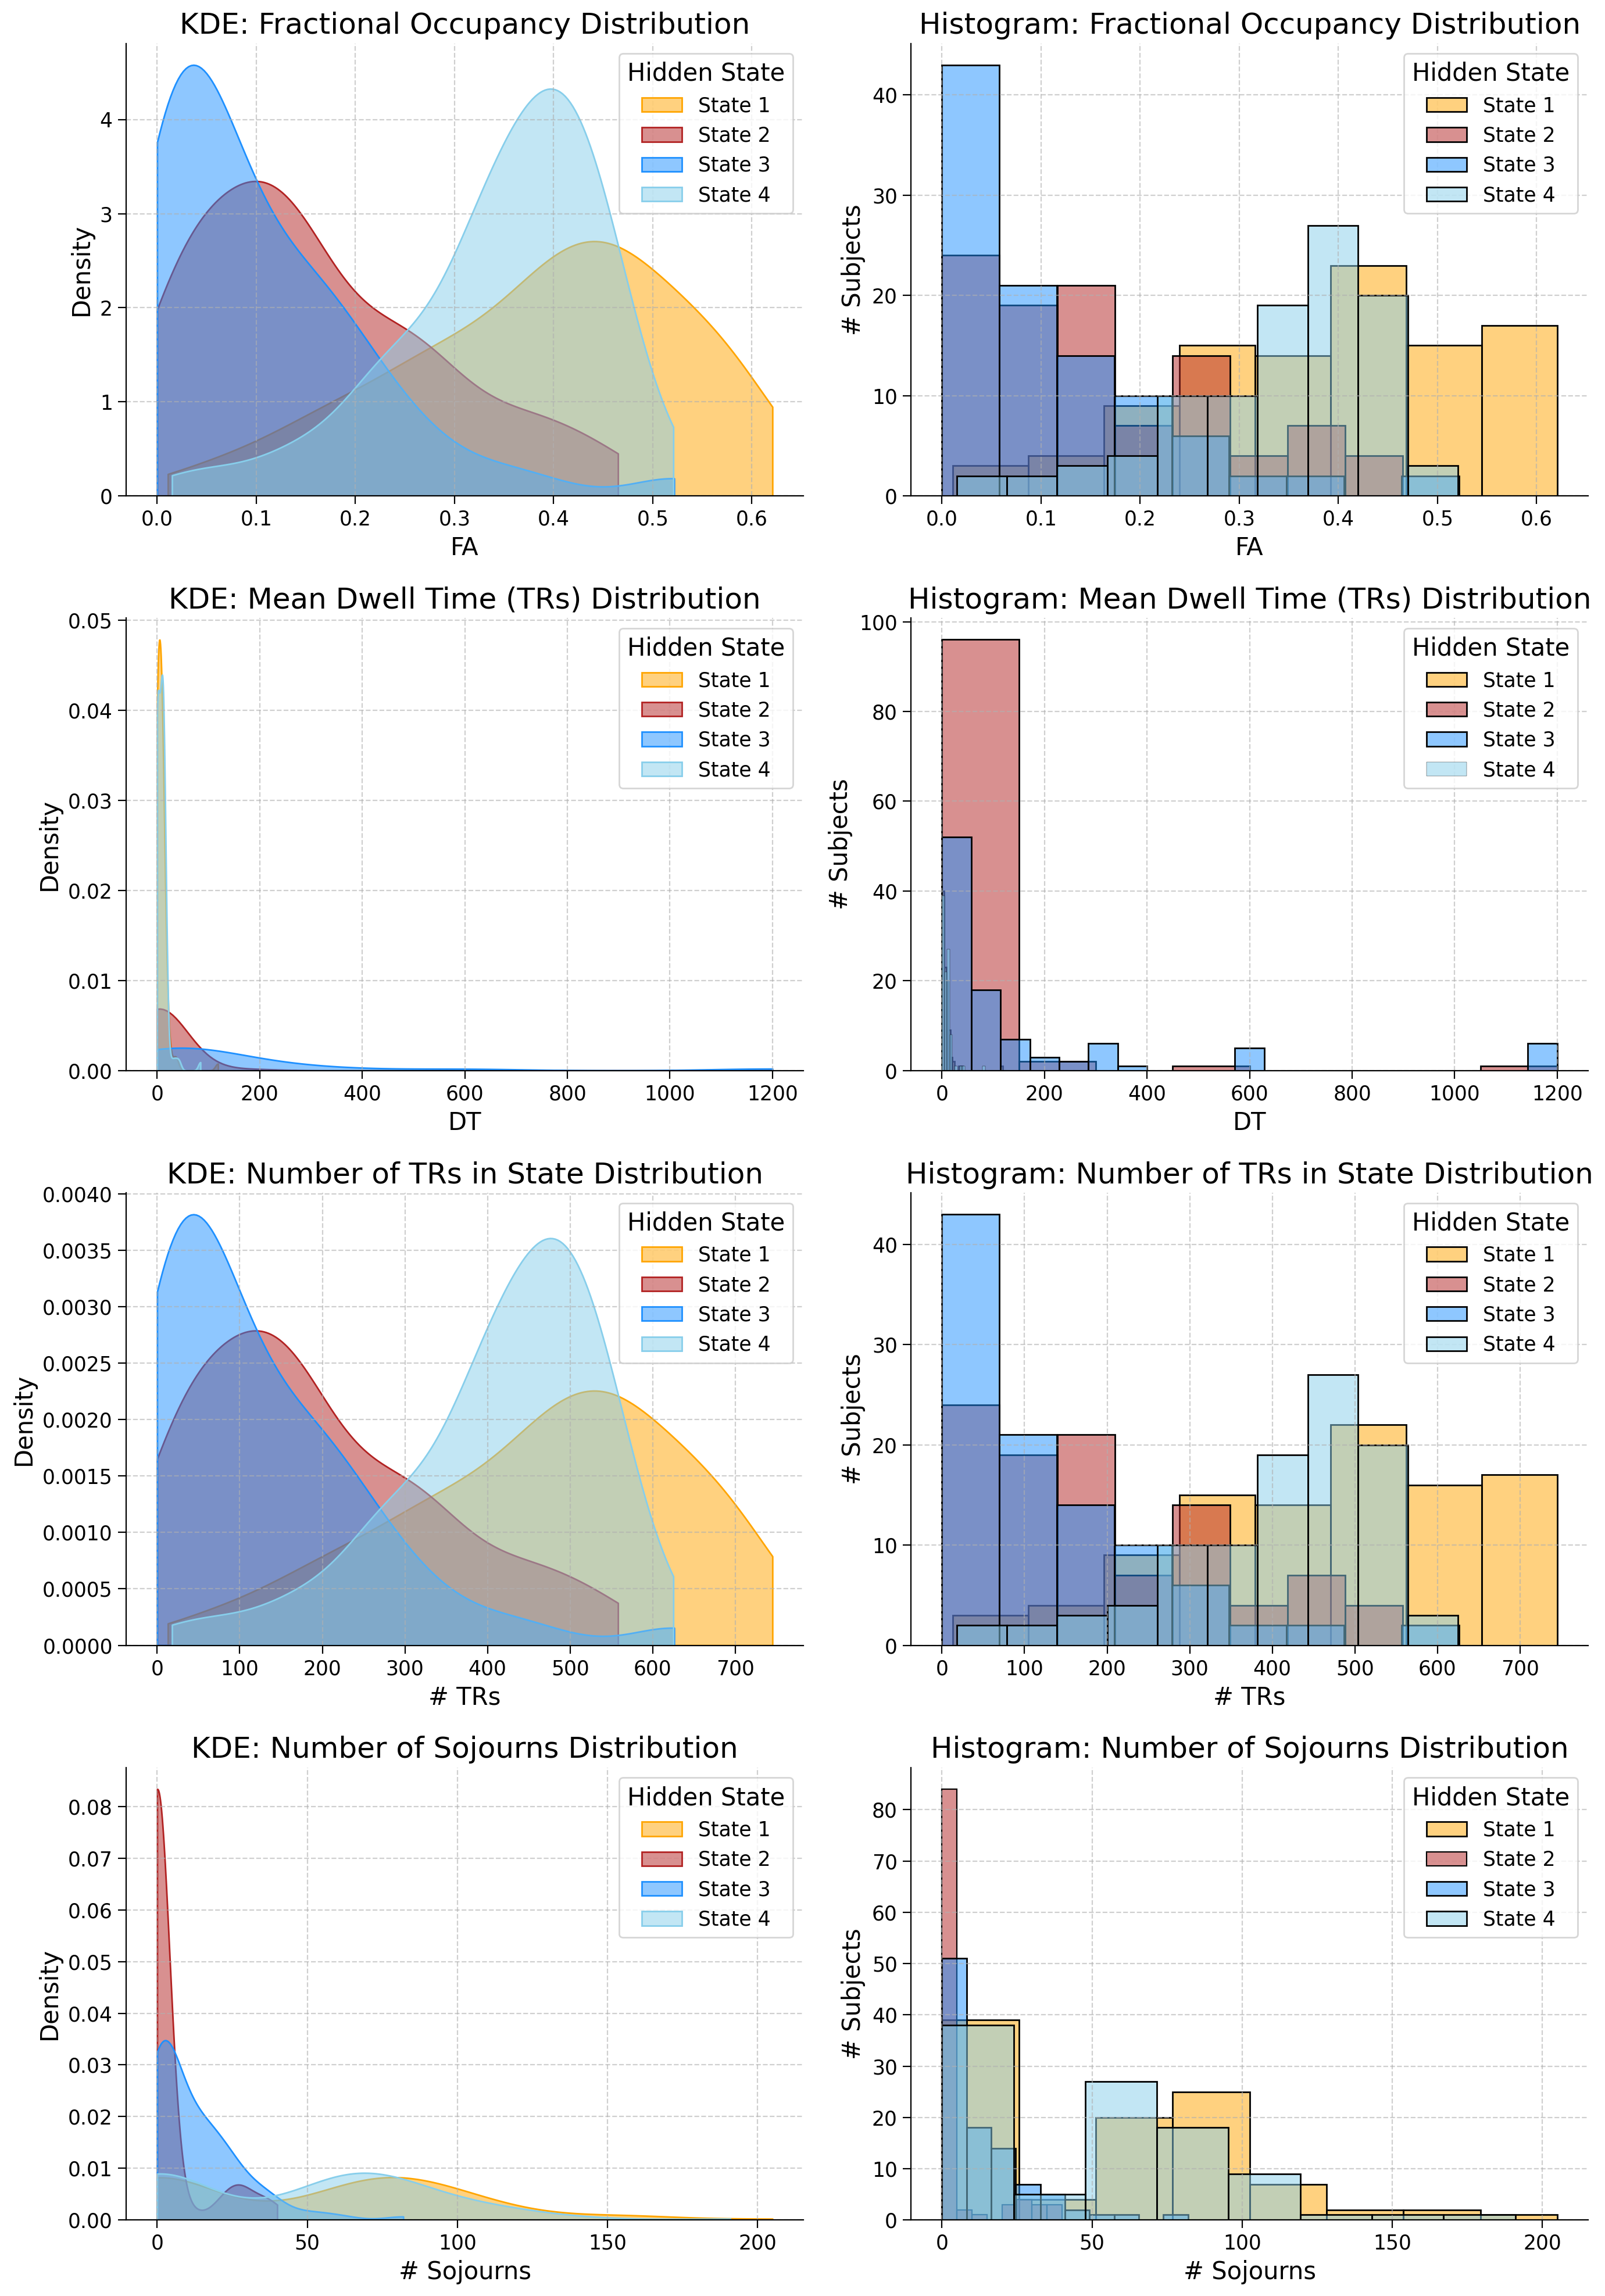

'\nmetric_data = {spec[2]: spec[0] for spec in plot_specs}\nmetric_names = [spec[2] for spec in plot_specs]\n\n# --- 2. Relationships WITHIN each state ---\nprint("--- Relationships WITHIN States (Correlation Matrices) ---")\nfor state_idx in range(num_states):\n    print(f"\nState {state_idx + 1}:")\n    state_df = pd.DataFrame({\n        name: metric_data[name][:, state_idx] for name in metric_names\n    })\n    corr_matrix = state_df.corr()\n    print(corr_matrix)\n\n    plt.figure(figsize=(6, 5))\n    sns.heatmap(corr_matrix, annot=True, cmap=\'coolwarm\', fmt=".2f", linewidths=.5)\n    plt.title(f\'Correlation Matrix for State {state_idx + 1}\')\n    plt.tight_layout()\n    plt.show()\n\n# --- 3. Relationships ACROSS all states (flattened data) ---\nprint("\n--- Relationships ACROSS All States (Overall Correlation Matrix) ---")\nflattened_data = {\n    name: metric_data[name].flatten() for name in metric_names\n}\noverall_df = pd.DataFrame(flattened_data)\noverall_corr_matrix = ov

In [ ]:
#subject_fractional_occupancies = np.array(subject_fractional_occupancies)
#subject_dwell_times = np.array(subject_dwell_times)
#subject_trs_in_state = np.array(subject_trs_in_state)
#subject_num_sojourns = np.array(subject_num_sojourns)


# Store your data arrays and labels in a list for easier iteration
'''
plot_specs = [
    (subject_fractional_occupancies, 'Fractional Occupancy', 'FA'),
    (subject_dwell_times, 'Mean Dwell Time (TRs)', 'DT'),
    (subject_trs_in_state, 'Number of TRs in State', '# TRs'),
    (subject_num_sojourns, 'Number of Sojourns', '# Sojourns')
]
'''
palette = ['Orange', 'Firebrick', 'Dodgerblue', 'Skyblue']

brain_states = ['State 1', 'State 2', 'State 3', 'State 4']
hue_order = brain_states

# Create a figure with 4 rows and 2 columns for the plots
fig, axes = plt.subplots(nrows=len(plot_specs), ncols=2, figsize=(14, 5 * len(plot_specs)))

# Loop through each metric (FA, DT, TRs, Sojourns)
for i, (data_array, title_prefix, x_label) in enumerate(plot_specs):

    # --- Left Subplot: KDE Plot (all states overlaid) ---
    ax_kde = axes[i, 0] # Current row, left column

    for state_idx in range(n_latent_states):
        current_state_data = data_array[:, state_idx]
        # Plot KDE
        sns.kdeplot(current_state_data, fill=True, alpha=0.5, label=f'State {state_idx+1}',
                    cut=0,  ax=ax_kde,color=palette[state_idx])

    ax_kde.set_title(f'KDE: {title_prefix} Distribution')
    ax_kde.set_xlabel(x_label)
    ax_kde.set_ylabel('Density')
    ax_kde.grid(True, linestyle='--', alpha=0.6)
    ax_kde.legend(title='Hidden State')

    # --- Right Subplot: Histogram (all states overlaid) ---
    ax_hist = axes[i, 1] # Current row, right column

    for state_idx in range(n_latent_states):
        current_state_data = data_array[:, state_idx]

        # Plot Histogram
        sns.histplot(current_state_data, bins='auto', alpha=0.5, label=f'State {state_idx+1}',
                     stat='count', # Number of subjects
                     edgecolor='black', ax=ax_hist,color=palette[state_idx])

    ax_hist.set_title(f'Histogram: {title_prefix} Distribution')
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel('# Subjects')
    ax_hist.grid(True, linestyle='--', alpha=0.6)
    ax_hist.legend(title='Hidden State')

plt.tight_layout()
plt.show()




'''
metric_data = {spec[2]: spec[0] for spec in plot_specs}
metric_names = [spec[2] for spec in plot_specs]

# --- 2. Relationships WITHIN each state ---
print("--- Relationships WITHIN States (Correlation Matrices) ---")
for state_idx in range(num_states):
    print(f"\nState {state_idx + 1}:")
    state_df = pd.DataFrame({
        name: metric_data[name][:, state_idx] for name in metric_names
    })
    corr_matrix = state_df.corr()
    print(corr_matrix)

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix for State {state_idx + 1}')
    plt.tight_layout()
    plt.show()

# --- 3. Relationships ACROSS all states (flattened data) ---
print("\n--- Relationships ACROSS All States (Overall Correlation Matrix) ---")
flattened_data = {
    name: metric_data[name].flatten() for name in metric_names
}
overall_df = pd.DataFrame(flattened_data)
overall_corr_matrix = overall_df.corr()
print(overall_corr_matrix)

plt.figure(figsize=(7, 6))
sns.heatmap(overall_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Overall Correlation Matrix Across All States and Subjects')
plt.tight_layout()
plt.show()

'''

In [ ]:
## - get inter-task intervals
'''- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
'''
task = "WM"
conditions = ["0bk_cor"]  # Run a subtraction analysis between two conditions

evs = [load_evs('0', task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
'''
contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)
'''
# Constants
TR = 0.72  # HCP TR
BLOCK_CONDITIONS = [
    '0bk_body', '0bk_faces', '0bk_nlr', '0bk_places', '0bk_tools',
    '2bk_body', '2bk_faces', '2bk_nlr', '2bk_places', '2bk_tools'
]



def get_rest_trs(subject, task_name, data_dir):
    all_blocks = []

    for cond in BLOCK_CONDITIONS:
        evs = load_evs(subject, task_name, cond, data_dir)
        for run_idx, ev in enumerate(evs):
            # Skip empty EVs
            if len(ev['onset']) == 0 or len(ev['duration']) == 0:
                continue

            onsets = np.atleast_1d(ev['onset'])
            durations = np.atleast_1d(ev['duration'])

            for onset, duration in zip(onsets, durations):
                all_blocks.append({
                    'run': run_idx,
                    'onset': onset,
                    'offset': onset + duration
                })


    # Convert to DataFrame and sort by run and onset
    df = pd.DataFrame(all_blocks).sort_values(by=['run', 'onset']).reset_index(drop=True)

    # Compute rest intervals between blocks
    rest_trs = []
    for run in df['run'].unique():
        run_blocks = df[df['run'] == run].sort_values(by='onset')
        for i in range(len(run_blocks) - 1):
            current_end = run_blocks.iloc[i]['offset']
            next_start = run_blocks.iloc[i + 1]['onset']

            if next_start > current_end:
                # Convert rest interval to TR indices
                start_tr = int(np.round(current_end / TR))
                end_tr = int(np.round(next_start / TR))
                rest_trs.extend([(run, tr) for tr in range(start_tr, end_tr)])

    return rest_trs  # List of (run, TR) tuples representing rest




In [ ]:
'''
print(np.shape(latent_brain_states)) # 4 x 360

timeseries_WM = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="WM",
                              dir=os.path.join(HCP_DIR, "hcp_task"))
  timeseries_WM.append(ts_concat)
timeseries_WM = np.asarray(timeseries_WM)

print(np.shape(timeseries_WM))
#(339, 360, 810)

subject_preferred_brainstate = pd.DataFrame({})
for subject, iSub in enumerate(subjects):
  rest_trs = get_rest_trs('0', 'WM', './DATA/hcp_task/')
  task0 = np.asarray([tr for run, tr in rest_trs if run == 0])
  task1 = np.asarray([tr for run, tr in rest_trs if run == 1])
  reduced_ts = timeseries_WM[;,0,[task0, task1+(405)]
  reduced_ts_latent_assignment = ## - assign each TR to a brain state
  preferred_states = np.mode(reduced_ts_latent_assignment ) # calculate brain state this subject is in the most
  subject_preferred_brainstate[subject] =
'''
tr = 0.72
lag_seconds = 5
lag_trs = int(np.round(lag_seconds / tr))  # e.g. 7
run_len = 405

brain_state_matrix = np.copy(state_mean_bold_patterns) # TODO replace with your brain states (need a 360 x s matrix)

fc_compare=False

num_states = brain_state_matrix.shape[0]
state_columns = [f"State {i+1}" for i in range(num_states)]

# Initialize DataFrame with columns
subject_preferred_brainstate = pd.DataFrame(columns=state_columns + ["Mode"])

for subject_idx, subject in enumerate(subjects):
    print(f"Processing subject: {subject}")

    # Get TRs during inter-block/task interval
    rest_trs = get_rest_trs(subject, 'WM', './DATA/hcp_task/')
    task0_trs = np.asarray([tr for run, tr in rest_trs if run == 0])
    task1_trs = np.asarray([tr for run, tr in rest_trs if run == 1])

    # Shift TRs by lag (forward in time: add lag_trs)
    task0_trs_lagged = task0_trs + lag_trs
    task1_trs_lagged = task1_trs + lag_trs

    # Clip so lagged TRs do not exceed run length - 1
    task0_trs_lagged = task0_trs_lagged[task0_trs_lagged < run_len]
    task1_trs_lagged = task1_trs_lagged[task1_trs_lagged < run_len]

    # Adjust task1_trs_lagged indices to concatenated space by adding run_len offset
    task1_trs_lagged_concat = task1_trs_lagged + run_len

    # Concatenate lagged TRs across runs
    all_task_trs_for_subject = np.concatenate((task0_trs_lagged, task1_trs_lagged_concat))


    # Extract subject time series for selected TRs, transpose to (n_TRs, n_features)
    reduced_ts_current_subject = timeseries_WM[subject_idx, :, all_task_trs_for_subject]

    if fc_compare:
        static_iti_fc = np.triu_indices(np.corrcoef(reduced_ts_current_subject))  # should give you upper triangle of 360x360
        cos_sim = cosine_similarity(reduced_ts_current_subject, brain_state_matrix) # brain state matrix should be
    else:
      # Compute cosine similarity between each TR and each brain state pattern
      cos_sim = cosine_similarity(reduced_ts_current_subject, brain_state_matrix)  # shape (n_TRs, n_states)

    # Assign each TR to the brain state with highest cosine similarity
    assignments = np.argmax(cos_sim, axis=1)  # shape (n_TRs,)

    # Count TRs assigned to each state
    counts = np.bincount(assignments, minlength=num_states)

    # Identify mode (most frequent) state
    preferred_state = np.argmax(counts)

    # Build row dictionary
    row = {f"State {i+1}": counts[i] for i in range(num_states)}
    row["Mode"] = preferred_state + 1  # add 1 to make brain states range from 1-4

    # Append to DataFrame
    subject_preferred_brainstate.loc[subject] = row



Processing subject: 0
Processing subject: 1
Processing subject: 2
Processing subject: 3
Processing subject: 4


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/0/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/1/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipyth

Processing subject: 5
Processing subject: 6
Processing subject: 7
Processing subject: 8
Processing subject: 9


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/5/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/5/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/6/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/6/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/7/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 10
Processing subject: 11
Processing subject: 12
Processing subject: 13


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/11/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/11/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/11/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/12/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/12/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 14
Processing subject: 15
Processing subject: 16
Processing subject: 17


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/15/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/15/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/16/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/16/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/16/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 18
Processing subject: 19
Processing subject: 20


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/19/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/19/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/19/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/20/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/21/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 21
Processing subject: 22
Processing subject: 23


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/23/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/23/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/24/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/24/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/24/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 24
Processing subject: 25
Processing subject: 26


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/26/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/26/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/27/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/27/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/27/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 27
Processing subject: 28


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/28/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/28/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 29
Processing subject: 30


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/30/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 31
Processing subject: 32
Processing subject: 33
Processing subject: 34


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/33/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/33/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/33/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/34/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/34/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 35
Processing subject: 36


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/35/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/35/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/36/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/36/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 37
Processing subject: 38
Processing subject: 39


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/38/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/38/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/38/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/39/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/39/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 40
Processing subject: 41
Processing subject: 42


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/41/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/41/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/41/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/41/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/42/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 43
Processing subject: 44
Processing subject: 45
Processing subject: 46


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/45/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/46/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 47
Processing subject: 48


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/47/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/47/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/47/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 49
Processing subject: 50
Processing subject: 51


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/49/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/49/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/50/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 52
Processing subject: 53


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/52/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/52/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/52/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/53/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/53/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 54
Processing subject: 55


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/54/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/55/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/55/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/55/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 56
Processing subject: 57


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/56/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/57/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/57/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/57/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 58
Processing subject: 59


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/58/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/58/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/58/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/58/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/59/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 60
Processing subject: 61


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/60/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/60/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/61/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 62
Processing subject: 63


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/62/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/63/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 64
Processing subject: 65
Processing subject: 66


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/64/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/64/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/64/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/65/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/65/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 67
Processing subject: 68


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/68/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/69/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/69/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 69
Processing subject: 70


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/70/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/70/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/70/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/71/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 71
Processing subject: 72


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/72/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/72/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/72/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/72/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/73/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 73
Processing subject: 74


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/74/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/74/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/75/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/75/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/75/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 75
Processing subject: 76
Processing subject: 77
Processing subject: 78
Processing subject: 79


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/76/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/77/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/79/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/79/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/80/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 80
Processing subject: 81
Processing subject: 82
Processing subject: 83
Processing subject: 84


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/81/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/81/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/82/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/82/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/82/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 85
Processing subject: 86
Processing subject: 87
Processing subject: 88
Processing subject: 89
Processing subject: 90


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/86/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/86/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/87/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/87/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/88/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 91
Processing subject: 92
Processing subject: 93
Processing subject: 94
Processing subject: 95
Processing subject: 96


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/92/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/92/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/92/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/93/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/93/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 97
Processing subject: 98
Processing subject: 99
Processing subject: 100
Processing subject: 101
Processing subject: 102


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/98/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/98/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/98/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/98/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/99/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/

Processing subject: 103
Processing subject: 104
Processing subject: 105
Processing subject: 106


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/103/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/103/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/104/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/104/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/105/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 107
Processing subject: 108
Processing subject: 109
Processing subject: 110
Processing subject: 111


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/107/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/107/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/108/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/108/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/108/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 112
Processing subject: 113
Processing subject: 114
Processing subject: 115
Processing subject: 116
Processing subject: 117


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/112/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/112/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/112/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/113/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/113/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 118
Processing subject: 119
Processing subject: 120
Processing subject: 121
Processing subject: 122
Processing subject: 123


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/118/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/118/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/118/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/118/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/119/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 124
Processing subject: 125
Processing subject: 126
Processing subject: 127


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/124/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/124/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/125/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/125/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/125/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 128
Processing subject: 129
Processing subject: 130
Processing subject: 131


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/128/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/128/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/129/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/130/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/131/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 132
Processing subject: 133
Processing subject: 134
Processing subject: 135


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/132/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/133/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/133/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/134/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/134/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 136
Processing subject: 137
Processing subject: 138


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/136/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/136/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/137/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/137/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/138/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 139
Processing subject: 140
Processing subject: 141
Processing subject: 142
Processing subject: 143
Processing subject: 144
Processing subject: 145


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/139/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/140/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 146
Processing subject: 147
Processing subject: 148
Processing subject: 149
Processing subject: 150
Processing subject: 151
Processing subject: 152


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/152/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/152/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/153/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/153/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/154/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 153
Processing subject: 154
Processing subject: 155
Processing subject: 156
Processing subject: 157
Processing subject: 158


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/158/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/158/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/158/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/159/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/159/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 159
Processing subject: 160
Processing subject: 161
Processing subject: 162
Processing subject: 163
Processing subject: 164
Processing subject: 165


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/165/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/166/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/167/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/167/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/167/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 166
Processing subject: 167
Processing subject: 168
Processing subject: 169
Processing subject: 170
Processing subject: 171
Processing subject: 172


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/172/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/172/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/173/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/173/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/174/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 173
Processing subject: 174
Processing subject: 175
Processing subject: 176
Processing subject: 177
Processing subject: 178
Processing subject: 179


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/179/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/179/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/180/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/180/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/181/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 180
Processing subject: 181
Processing subject: 182
Processing subject: 183
Processing subject: 184
Processing subject: 185
Processing subject: 186


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/186/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/186/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/186/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/187/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/187/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 187
Processing subject: 188
Processing subject: 189
Processing subject: 190
Processing subject: 191
Processing subject: 192
Processing subject: 193


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/193/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/193/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/193/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/196/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/196/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 194
Processing subject: 195
Processing subject: 196
Processing subject: 197
Processing subject: 198
Processing subject: 199
Processing subject: 200


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/199/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/200/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 201
Processing subject: 202
Processing subject: 203
Processing subject: 204
Processing subject: 205
Processing subject: 206
Processing subject: 207
Processing subject: 208


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/207/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/207/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/207/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/208/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/208/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 209
Processing subject: 210
Processing subject: 211
Processing subject: 212
Processing subject: 213
Processing subject: 214
Processing subject: 215
Processing subject: 216


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/214/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/215/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/215/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/215/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/216/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 217
Processing subject: 218
Processing subject: 219
Processing subject: 220
Processing subject: 221
Processing subject: 222
Processing subject: 223
Processing subject: 224


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/223/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/223/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/224/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/224/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/225/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 225
Processing subject: 226
Processing subject: 227
Processing subject: 228
Processing subject: 229
Processing subject: 230
Processing subject: 231
Processing subject: 232


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/230/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/230/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/231/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/231/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/231/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 233
Processing subject: 234
Processing subject: 235
Processing subject: 236
Processing subject: 237
Processing subject: 238
Processing subject: 239


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/237/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/238/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/238/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/238/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/239/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 240
Processing subject: 241
Processing subject: 242
Processing subject: 243
Processing subject: 244
Processing subject: 245
Processing subject: 246
Processing subject: 247
Processing subject: 248
Processing subject: 249
Processing subject: 250
Processing subject: 251
Processing subject: 252
Processing subject: 253
Processing subject: 254


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/247/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/247/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/249/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/249/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/252/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 255
Processing subject: 256
Processing subject: 257
Processing subject: 258
Processing subject: 259
Processing subject: 260
Processing subject: 261


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/261/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/261/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/262/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/262/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/262/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 262
Processing subject: 263
Processing subject: 264
Processing subject: 265
Processing subject: 266
Processing subject: 267
Processing subject: 268


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/268/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/269/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/269/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/269/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/270/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 269
Processing subject: 270
Processing subject: 271
Processing subject: 272
Processing subject: 273
Processing subject: 274
Processing subject: 275


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/275/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/275/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/275/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/277/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/277/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 276
Processing subject: 277
Processing subject: 278
Processing subject: 279
Processing subject: 280
Processing subject: 281


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/281/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/282/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/282/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/283/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/283/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 282
Processing subject: 283
Processing subject: 284
Processing subject: 285
Processing subject: 286
Processing subject: 287
Processing subject: 288
Processing subject: 289
Processing subject: 290
Processing subject: 291
Processing subject: 292
Processing subject: 293
Processing subject: 294
Processing subject: 295


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/289/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/289/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/289/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/290/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/291/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 296
Processing subject: 297
Processing subject: 298
Processing subject: 299
Processing subject: 300
Processing subject: 301
Processing subject: 302


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/296/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/297/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/298/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/298/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/299/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 303
Processing subject: 304
Processing subject: 305
Processing subject: 306
Processing subject: 307
Processing subject: 308
Processing subject: 309


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/303/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/303/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/304/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/307/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/307/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 310
Processing subject: 311
Processing subject: 312
Processing subject: 313
Processing subject: 314
Processing subject: 315
Processing subject: 316


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/310/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/310/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/310/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/311/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/312/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 317
Processing subject: 318
Processing subject: 319
Processing subject: 320
Processing subject: 321
Processing subject: 322
Processing subject: 323
Processing subject: 324


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/318/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/318/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/318/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/319/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/319/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 325
Processing subject: 326
Processing subject: 327
Processing subject: 328
Processing subject: 329
Processing subject: 330
Processing subject: 331
Processing subject: 332


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/325/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/326/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/326/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/327/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/327/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


Processing subject: 333
Processing subject: 334
Processing subject: 335
Processing subject: 336
Processing subject: 337
Processing subject: 338


/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/333/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/334/EVs/tfMRI_WM_RL/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/334/EVs/tfMRI_WM_LR/0bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/334/EVs/tfMRI_WM_RL/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
/tmp/ipython-input-9-1895567192.py:99: UserWarning: loadtxt: input contained no data: "./DATA/hcp_task/subjects/334/EVs/tfMRI_WM_LR/2bk_nlr.txt"
  ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)


     State 1  State 2  State 3  State 4  Mode
0         18       46       30       44     2
1         32       34       29       43     4
2         27       70       57       74     4
3         37      154      114       78     2
4         57       62       68       47     3
..       ...      ...      ...      ...   ...
334       19       30       34       58     4
335        9       82       43       64     2
336       20       44       12       84     4
337       34       98       40       88     2
338        8       56       45       71     4

[339 rows x 5 columns]


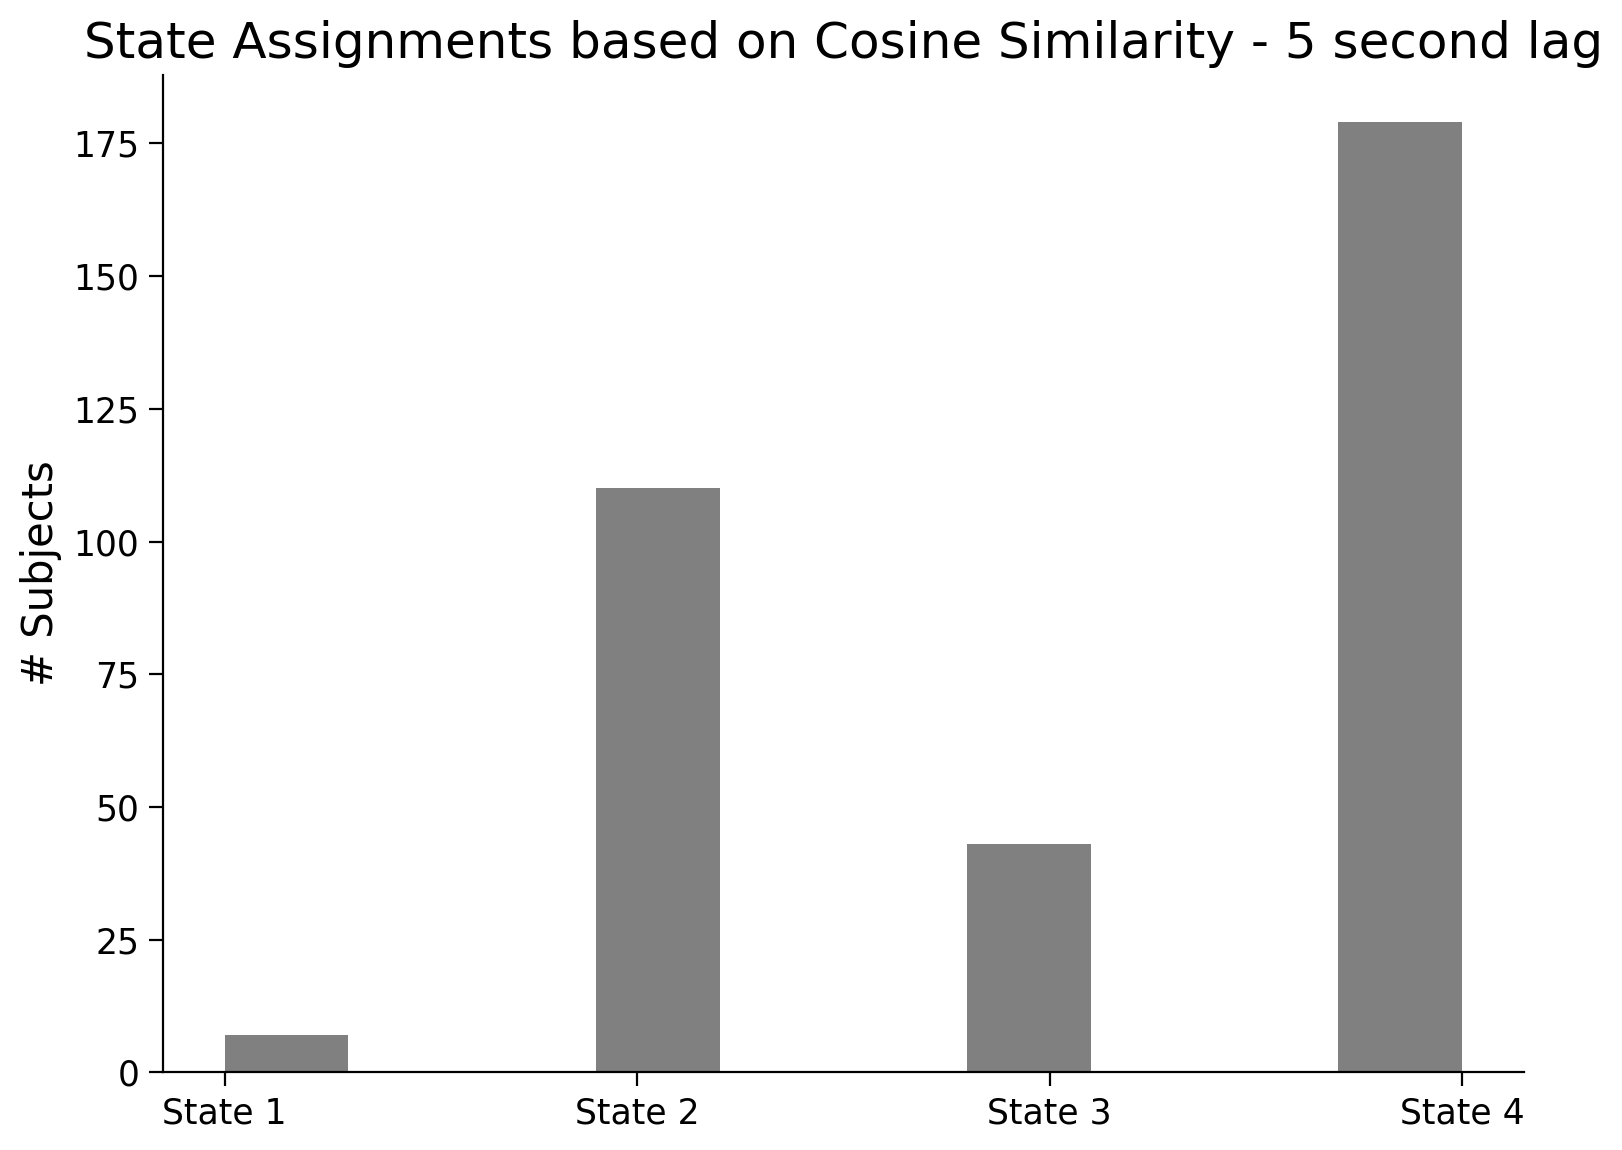

      index Brain State  Value
0         0     State 1     18
1         1     State 1     32
2         2     State 1     27
3         3     State 1     37
4         4     State 1     57
...     ...         ...    ...
1351    334     State 4     58
1352    335     State 4     64
1353    336     State 4     84
1354    337     State 4     88
1355    338     State 4     71

[1356 rows x 3 columns]


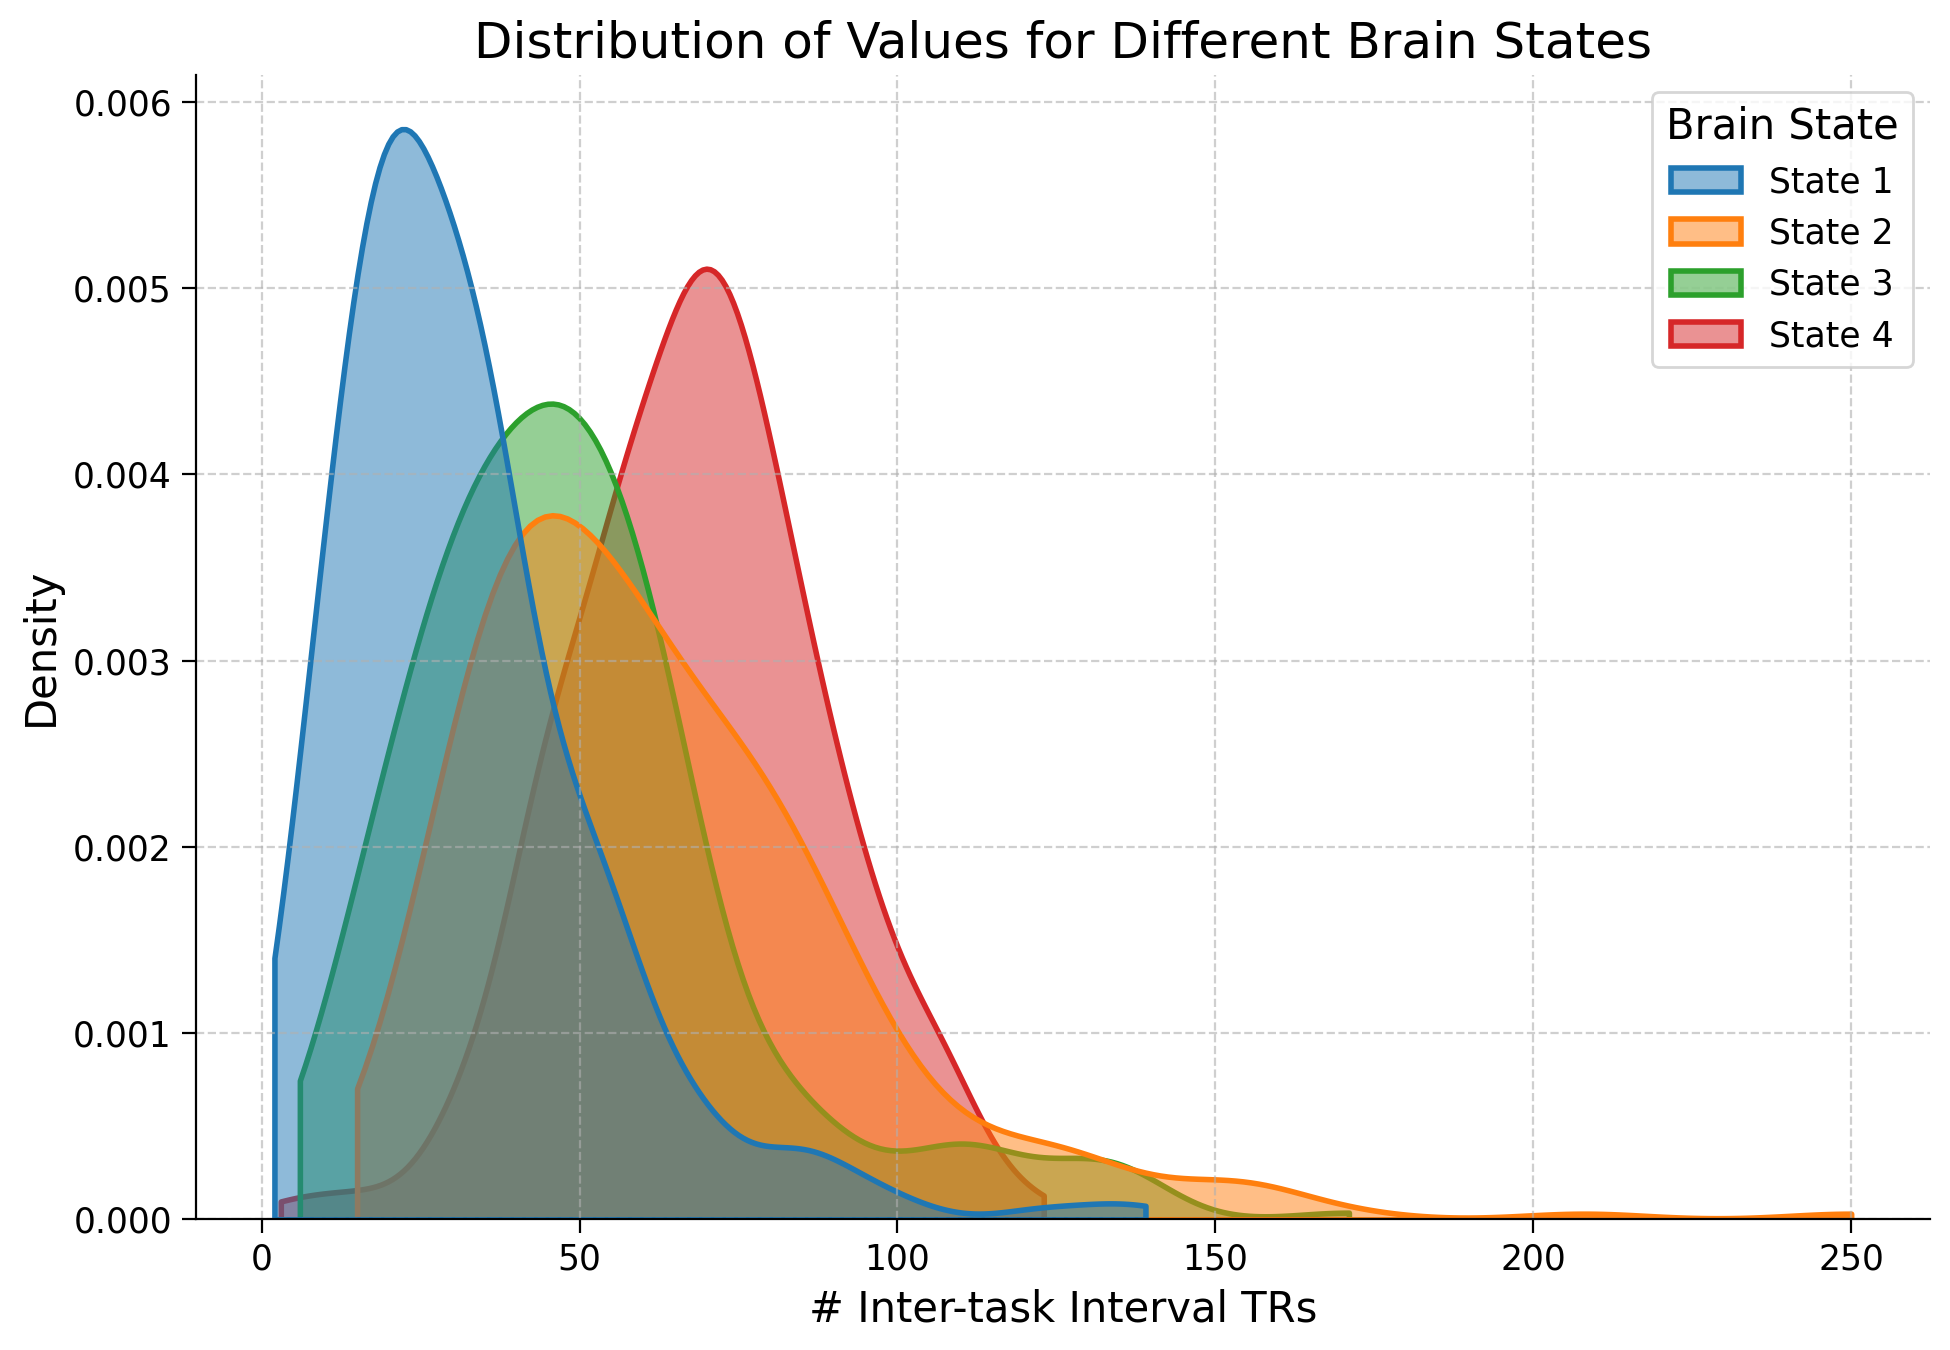

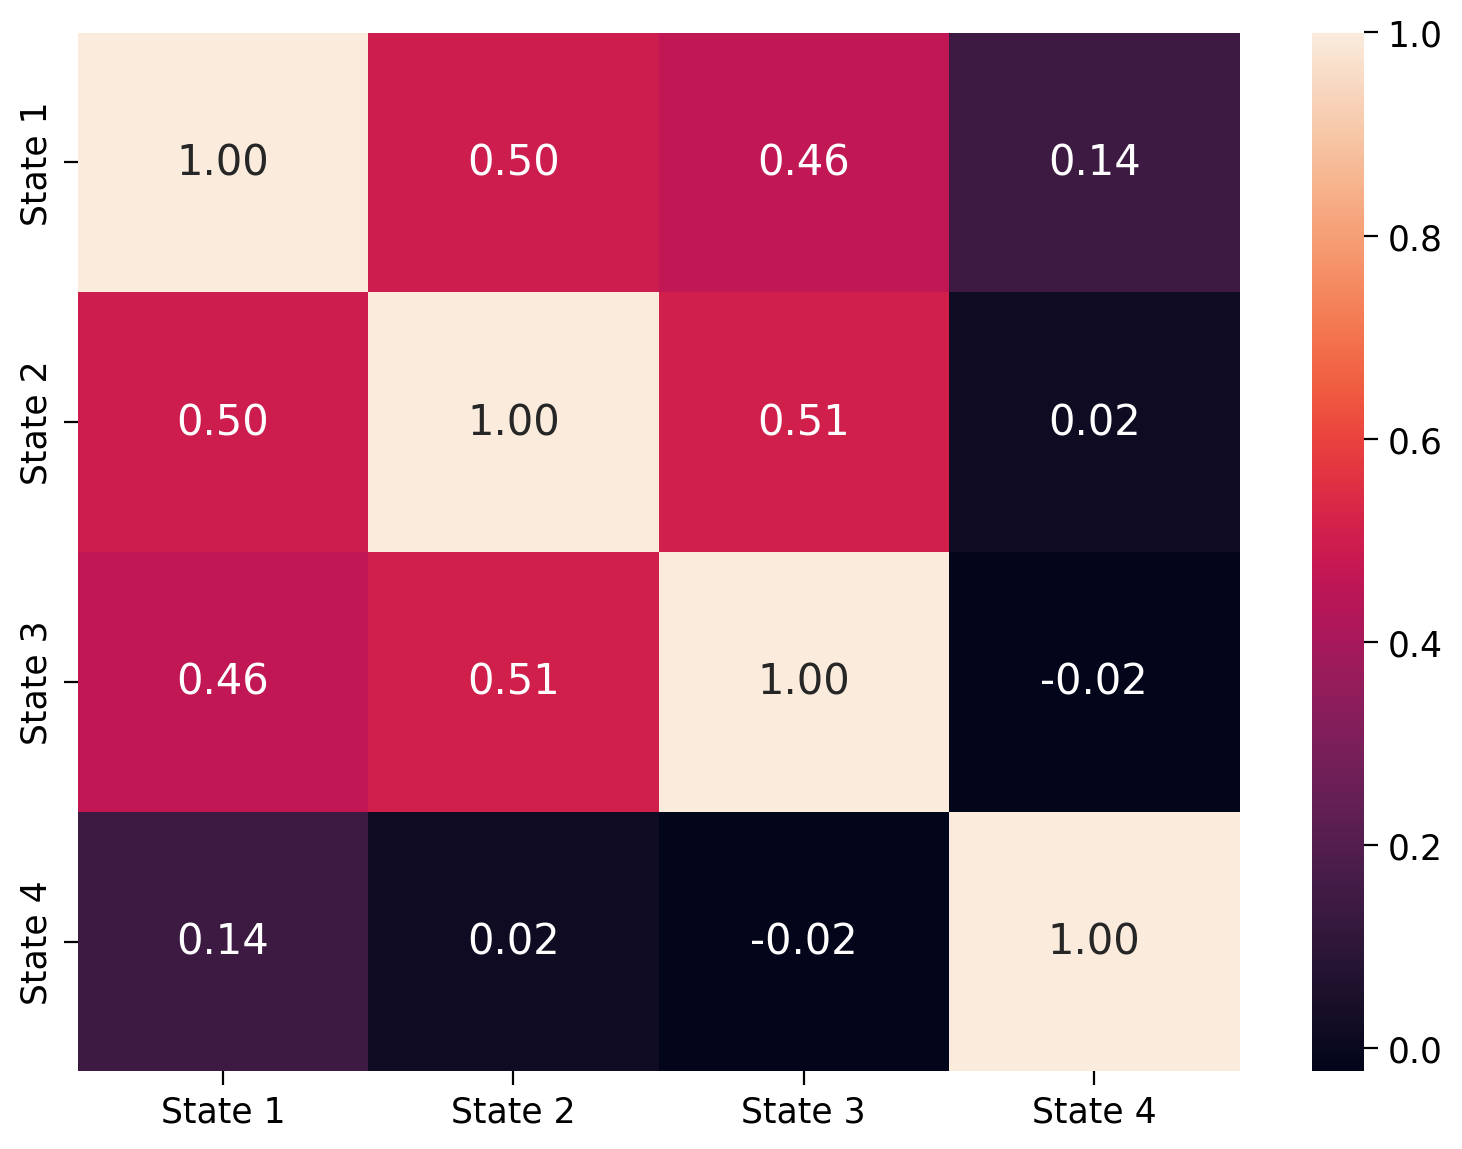

In [ ]:
print(subject_preferred_brainstate)


plt.hist(subject_preferred_brainstate['Mode'],color='grey')
plt.title("State Assignments based on Cosine Similarity - 5 second lag")
plt.ylabel('# Subjects')
plt.xticks(np.arange(n_latent_states)+1, state_labels,)
plt.show()


melted_df = subject_preferred_brainstate[subject_preferred_brainstate.columns[:4]].reset_index().melt(var_name='Brain State', id_vars='index', value_name='Value')

# --- Create the single KDE plot ---
plt.figure(figsize=(10, 7)) # Adjust figure size for better visualization

sns.kdeplot(data=melted_df, x='Value', hue='Brain State',
            fill=True, alpha=0.5, linewidth=2,
            cut=0) # Use cut=0 as requested, good for non-negative data

plt.title('Distribution of Values for Different Brain States')
plt.xlabel('# Inter-task Interval TRs') # This label will depend on what the values in your DataFrame represent
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



sns.heatmap(subject_preferred_brainstate[subject_preferred_brainstate.columns[:4]].corr(),annot=True, fmt='.2f')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mode
4    177
2    109
3     43
1      7
Name: count, dtype: int64
Kruskal-Wallis test: H = 6.410, p = 0.093


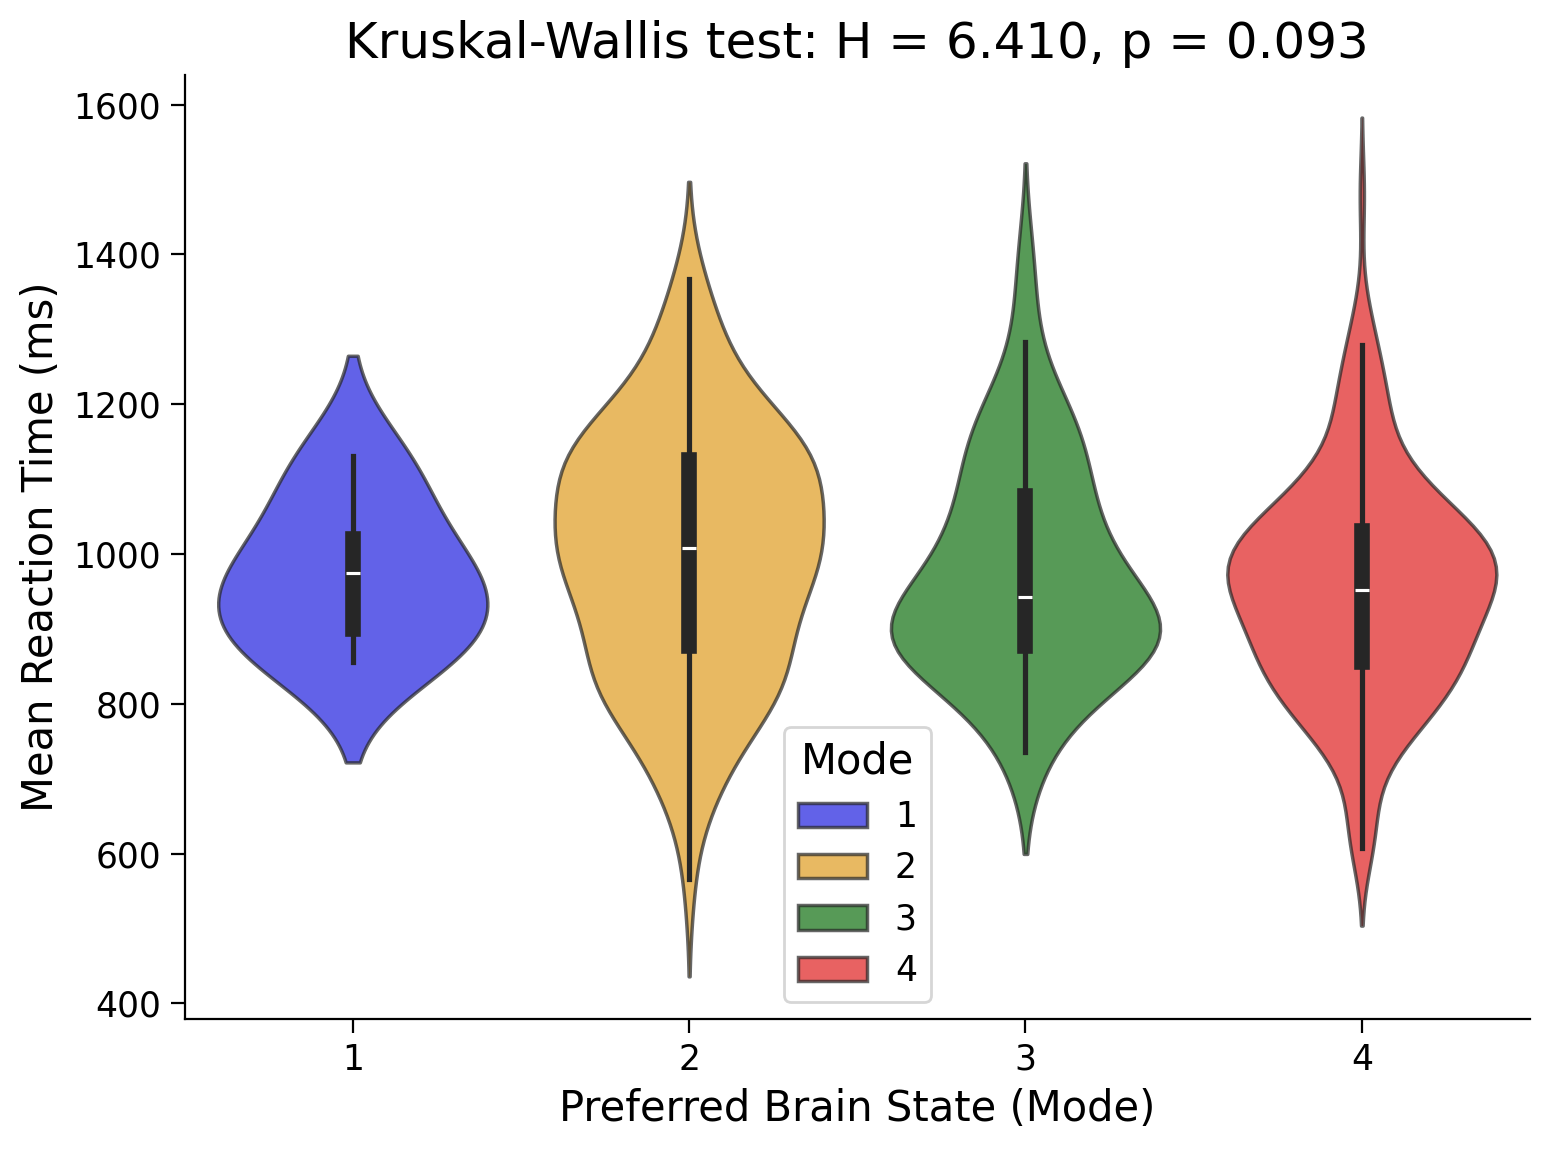

Kruskal-Wallis test (excluding Mode 0): H = 6.341, p = 0.042


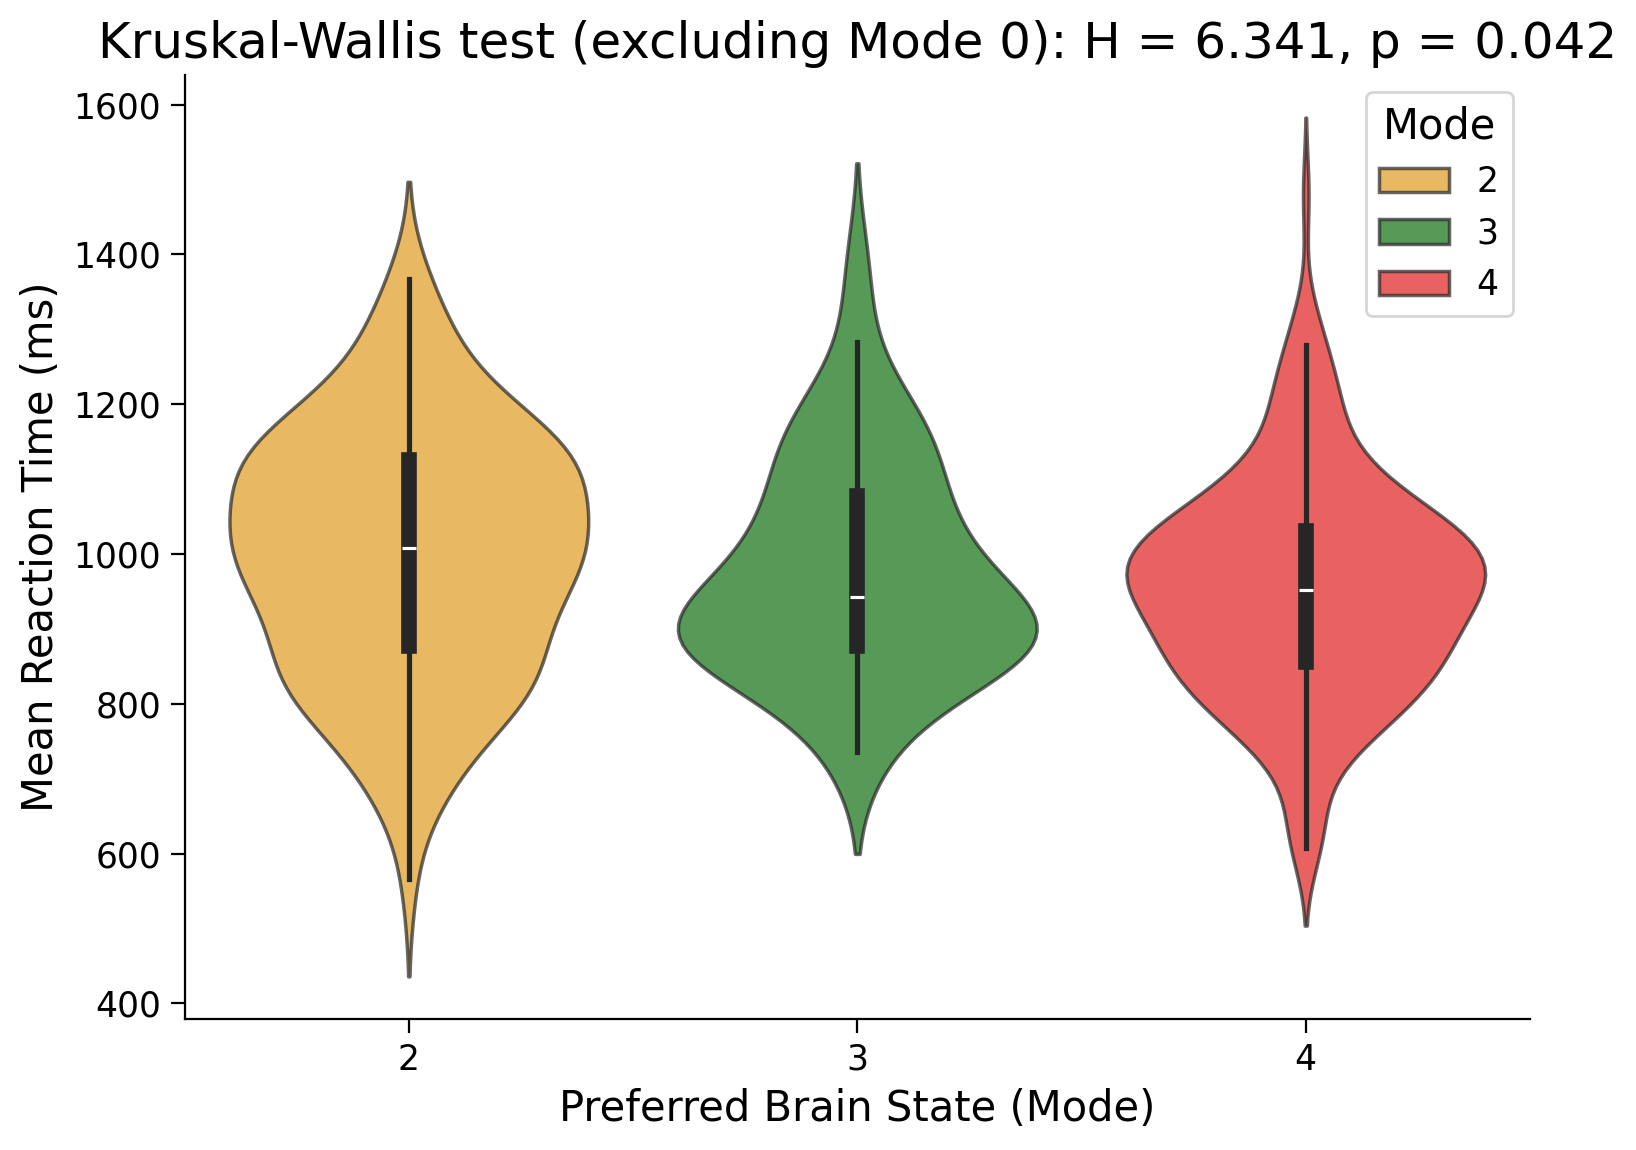

In [ ]:
## - neurobehavioral analysis

wm_behavior = pd.DataFrame(np.genfromtxt(os.path.join(HCP_DIR, "hcp", "behavior", "wm.csv"),
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf"))


# Get 2-back condition
two_back_df = wm_behavior[wm_behavior['ConditionName'].str.startswith('2BK')]

# Group by subject and get mean median RT across runsand conditions
subject_rt = two_back_df.groupby('Subject')['MEDIAN_RT'].mean()

# - now perform group analysis
df_raw = subject_preferred_brainstate[['Mode']].copy()
df_raw['Mean_RT'] = subject_rt  # assuming subject_rt has matching index

df = df_raw[~df_raw['Mean_RT'].isnull()]            # remove NaNs
df = df[np.isfinite(df['Mean_RT'])]               # remove inf/-inf

print(df['Mode'].value_counts())



groups = [df.loc[df['Mode'] == state, 'Mean_RT'].values for state in sorted(df['Mode'].unique())]

# Check normality and variance assumptions if you want, otherwise:
# If small group sizes or non-normality suspected, do Kruskal-Wallis (non-parametric):
stat, pval = stats.kruskal(*groups)
print(f"Kruskal-Wallis test: H = {stat:.3f}, p = {pval:.3f}")

sns.violinplot(x='Mode', y='Mean_RT', data=df,hue='Mode',palette=['blue', 'orange','green','red'],alpha=.7)
plt.xlabel('Preferred Brain State (Mode)')
plt.ylabel('Mean Reaction Time (ms)')
plt.title(f"Kruskal-Wallis test: H = {stat:.3f}, p = {pval:.3f}")
plt.show()



## - exclude brain state 0 because it has way too few subjects
# Filter out Mode 0
df_filtered = df[df['Mode'] != 1]

groups = [df_filtered.loc[df_filtered['Mode'] == state, 'Mean_RT'].values for state in sorted(df_filtered['Mode'].unique())]


stat, pval = stats.kruskal(*groups)
print(f"Kruskal-Wallis test (excluding Mode 0): H = {stat:.3f}, p = {pval:.3f}")

# Plot
sns.violinplot(x='Mode', y='Mean_RT', hue='Mode',data=df_filtered,palette=['orange','green','red'],alpha=.7)
plt.xlabel('Preferred Brain State (Mode)')
plt.ylabel('Mean Reaction Time (ms)')
plt.title(f"Kruskal-Wallis test (excluding Mode 0): H = {stat:.3f}, p = {pval:.3f}")
plt.show()

In [ ]:
## post hoc tests

In [ ]:
## post hoc tests
# Unique brain state modes in your filtered DataFrame
def get_posthoc_results(df):
  modes = sorted(df['Mode'].unique())

  # Get all pairwise combinations of modes
  pairwise_comparisons = list(itertools.combinations(modes, 2))

  # Store results
  results = []

  for m1, m2 in pairwise_comparisons:
      rt1 = df[df['Mode'] == m1]['Mean_RT'].dropna()
      rt2 = df[df['Mode'] == m2]['Mean_RT'].dropna()

      stat, p = mannwhitneyu(rt1, rt2, alternative='two-sided')

      results.append({
          'Comparison': f'{m1} vs {m2}',
          'U-statistic': stat,
          'Raw p-value': p
      })

  # Convert to DataFrame
  results_df = pd.DataFrame(results)

  # Bonferroni correction
  results_df['Bonferroni-corrected p'] = results_df['Raw p-value'] * len(results_df)
  results_df['Significant'] = results_df['Bonferroni-corrected p'] < 0.05

  # Ensure p-values don't exceed 1
  results_df['Bonferroni-corrected p'] = results_df['Bonferroni-corrected p'].clip(upper=1.0)

  print(results_df)
  return results_df
results_df = get_posthoc_results(df)
results_df_filtered = get_posthoc_results(df_filtered)

  Comparison  U-statistic  Raw p-value  Bonferroni-corrected p  Significant
0     0 vs 1        331.0     0.569754                1.000000        False
1     0 vs 2        155.0     0.912914                1.000000        False
2     0 vs 3        675.0     0.690665                1.000000        False
3     1 vs 2       2594.5     0.305495                1.000000        False
4     1 vs 3      11378.5     0.010803                0.064817        False
5     2 vs 3       4013.0     0.580334                1.000000        False
  Comparison  U-statistic  Raw p-value  Bonferroni-corrected p  Significant
0     1 vs 2       2594.5     0.305495                0.916485        False
1     1 vs 3      11378.5     0.010803                0.032408         True
2     2 vs 3       4013.0     0.580334                1.000000        False
